INICIANDO MODELAGEM

Será utilizado três modelos com objetivo de pratica-los, ou seja, pode ser que eles não sejam os mais adequados para este projeto.
- Regressão Logistica
- Random Forest
- SVM

In [2]:
import pandas as pd
import numpy as np

df_model_original = pd.read_parquet('df_final_para_modeling.parquet')

df_model = df_model_original.copy()

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497942 entries, 0 to 551442
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   Artist(s)                       497942 non-null  object         
 1   song                            497942 non-null  object         
 2   text                            497942 non-null  object         
 3   Length                          497942 non-null  timedelta64[ns]
 4   emotion                         497942 non-null  object         
 5   Genre                           497942 non-null  object         
 6   Album                           497942 non-null  object         
 7   Release Date                    497942 non-null  object         
 8   Key                             497942 non-null  object         
 9   Tempo_bpm                       497942 non-null  int64          
 10  Loudness (db)                   497942 non-null  

(Divide treino/teste -> Escaloneia -> Treina SVM -> Avalia -> Treina Reg. Logística -> Avalia -> Compara)

Ao realizar os primeiros testes do modelo e ajustes, pode-se observar a dificuldade do modelo random forest generalizar entre a classe joy (1) e negative valence (3)

A partir da exploração da feature, observou-se que o modelo esta dando muita importância a uma feature muita fraca, que não sinaliza as diferenças entre estas duas classes. A partir disso será criada uma feature de interação, com a intenção de aumentar a a difenrenciação que o modelo faz entre esta duas classes.

In [3]:
df_model['Good for Exercise'].info()

<class 'pandas.core.series.Series'>
Index: 497942 entries, 0 to 551442
Series name: Good for Exercise
Non-Null Count   Dtype
--------------   -----
497942 non-null  bool 
dtypes: bool(1)
memory usage: 4.3 MB


Text(0.5, 0, 'Energy')

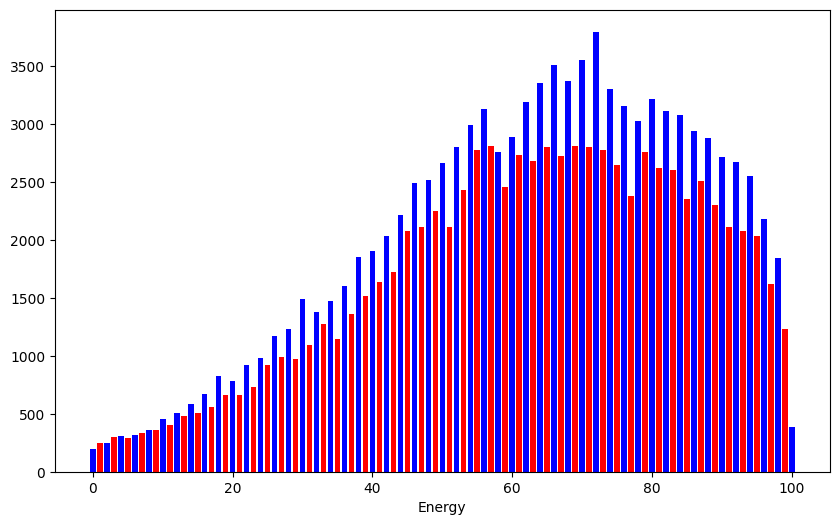

In [4]:
import matplotlib.pyplot as plt

# Seleciona apenas as linhas onde a coluna 'emotion' é 'joy' ou 'negative_valence'
df_model_emotions = df_model[df_model['emotion'].isin(['joy', 'negative_valence'])].groupby('Energy').size().reset_index(name='count')

df_model_emotions

plt.figure(figsize=(10, 6))
plt.bar(df_model_emotions['Energy'], df_model_emotions['count'], color=['blue', 'red'])
plt.xlabel('Energy')


In [5]:
# Criando feature de interação entre 'Energy' e 'Good for Exercise',
# foi escolhido 'Good for Exercise' pois esta feature é a que tem maior 
# potencial de generalização entre a classe joy e nevative valence

df_model['energy_x_good_for_exercise'] = df_model.apply(
    lambda row: row['Energy'] * 2 if row['Good for Exercise'] == True else row['Energy'],
    axis=1
)

print(df_model[['Good for Exercise', 'energy_x_good_for_exercise', 'Energy']].head(40))

    Good for Exercise  energy_x_good_for_exercise  Energy
0               False                          83      83
1               False                          85      85
2                True                         178      89
3                True                         168      84
4                True                         142      71
5                True                         162      81
6               False                          89      89
7               False                          88      88
8               False                          72      72
9                True                         136      68
10              False                          76      76
11              False                          93      93
12               True                         160      80
13               True                         166      83
14              False                          99      99
15               True                         184      92
16            

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Criando o DataFrame com as features selecionadas
features = ['Tempo_bpm', 'energy_x_good_for_exercise', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 
            'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 
            'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 
            'Good for Running', 'Good for Driving', 'Good for Social Gatherings', 
            'Good for Morning Routine']

X = df_model[features]

In [7]:
# Criando target com encoder
y_text = df_model['emotion_grouped']


y = LabelEncoder().fit_transform(y_text)

for i, classe in enumerate(LabelEncoder().fit(y_text).classes_):
    print(f'Classe {i}: {classe}')

Classe 0: anger
Classe 1: joy
Classe 2: love
Classe 3: negative_valence
Classe 4: others


In [8]:
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print(f'\n treino {X_train.shape[0]}')
print(f'\n teste {X_test.shape[0]}')


 treino 398353

 teste 99589


In [9]:
# Aplicando SMOTE para balancear as classes no conjunto de treino
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nTamanho de X_train após SMOTE: {X_train_resampled.shape}")
print(f"Distribuição das classes em y_train após SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")


Tamanho de X_train após SMOTE: (757290, 17)
Distribuição das classes em y_train após SMOTE:
0    151458
1    151458
3    151458
2    151458
4    151458
Name: count, dtype: int64


In [10]:
# Criando pipeline

scaler = StandardScaler()


log_reg = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    random_state=21
)

pipeline_log_reg = Pipeline(steps=[
        ('scaler', scaler),
        ('classifier', log_reg)
])

print('\n treinando modelo...')

pipeline_log_reg.fit(X_train_resampled, y_train_resampled)

print('\n Sucesso')


 treinando modelo...


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



 Sucesso


Dentro do modelo de regressão logistica foi escolhido o método one-vs-rest. Sustentando na justificativa de que o objetivo do projeto é identificar (diagnosticar) o sentimento transmitido pela música, atraves da classificação de emoções, ou seja, o modelo tem que performar bem individualmente (em cada classe) e não de forma geral.
Diferente da regressão softmax, que "encaixa" a entrada em uma das classes com base na sua maior probabilidade o que performaria bem para acertar em valores absolutos, aqui interessa também performar o perfil de cada classe, comparando ela com as demais (ovr).

In [11]:
#Aplicando validação cruzada
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

kfold_stratify = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

print('\n Iniciando validação cruzada...')

scores = cross_val_score(
    estimator=pipeline_log_reg,
    X=X_train_resampled,
    y=y_train_resampled,
    cv=kfold_stratify,
    scoring='f1_macro'
)

print('\n Validação cruzada concluída')
print(f'Scores em cada fold: {scores}')
print(f'média do F1-score: {np.mean(scores):.4f}')
print(f'desvio padrão do F1-score: {np.std(scores):.4f}')


 Iniciando validação cruzada...


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\AppData\Local\Pr


 Validação cruzada concluída
Scores em cada fold: [0.27488304 0.27231529 0.27446479 0.27288852 0.27454709]
média do F1-score: 0.2738
desvio padrão do F1-score: 0.0010


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Random Forest não precisa de escalonamento, mas manter o scaler no pipeline não atrapalha
# e mantém a estrutura para testar outros modelos depois.
pipeline_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=42))
])

# Use a mesma estratégia de validação cruzada
kfold_estratificado = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Iniciando a Validação Cruzada com Random Forest...")
scores_rf = cross_val_score(
    estimator=pipeline_rf, 
    X=X_train_resampled, 
    y=y_train_resampled, 
    cv=kfold_estratificado,
    scoring='f1_macro' 
)

print("\nResultados do Random Forest:")
print(f"Scores em cada um dos 5 'folds': {scores_rf}")
print(f"Média do F1-Score: {np.mean(scores_rf):.4f}")
print(f"Desvio Padrão do F1-Score: {np.std(scores_rf):.4f}")

Iniciando a Validação Cruzada com Random Forest...

Resultados do Random Forest:
Scores em cada um dos 5 'folds': [0.65322156 0.65470403 0.65517875 0.65548272 0.65476864]
Média do F1-Score: 0.6547
Desvio Padrão do F1-Score: 0.0008


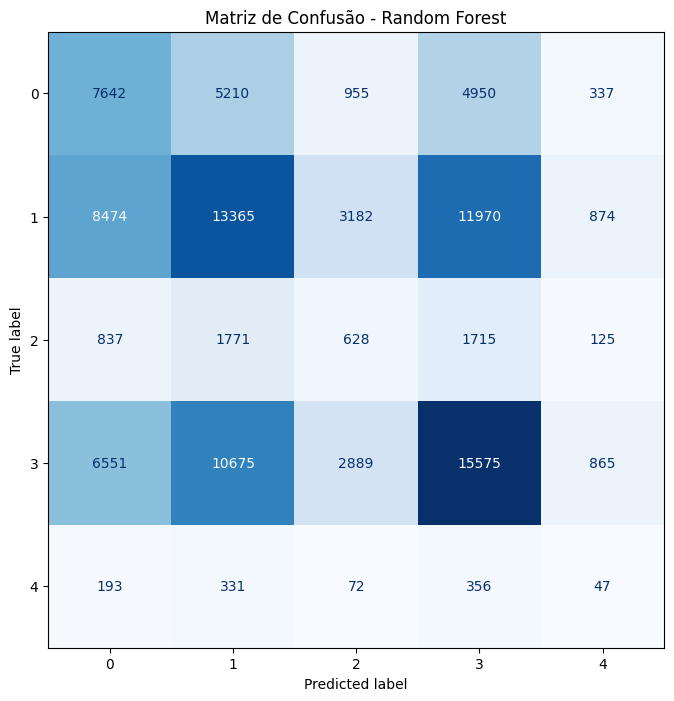

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Treina o modelo Random Forest no conjunto de treino completo
pipeline_rf.fit(X_train_resampled, y_train_resampled)

# Faz previsões no conjunto de teste
y_pred_rf = pipeline_rf.predict(X_test)

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Matriz de Confusão - Random Forest')
plt.show()

Importância das features no Random Forest:
Tempo_bpm                         0.149959
Positiveness                      0.146609
Danceability                      0.130861
Liveness                          0.124384
Acousticness                      0.119498
energy_x_good_for_exercise        0.094397
Energy                            0.091680
Speechiness                       0.082060
Instrumentalness                  0.043162
Good for Morning Routine          0.003248
Good for Driving                  0.003098
Good for Work/Study               0.002519
Good for Exercise                 0.002292
Good for Running                  0.002118
Good for Party                    0.002114
Good for Relaxation/Meditation    0.001174
Good for Social Gatherings        0.000826
dtype: float64


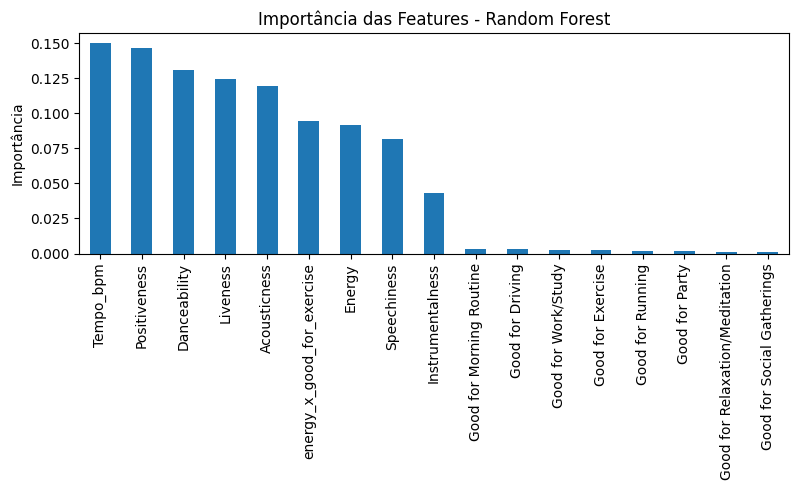

In [14]:
import pandas as pd

# Verificando a importância das features no modelo Random Forest
import matplotlib.pyplot as plt

# Garante que o pipeline está treinado (caso não esteja)
if not hasattr(pipeline_rf.named_steps['classifier'], "feature_importances_"):
	pipeline_rf.fit(X_train_resampled, y_train_resampled)

# Acessa o estimador RandomForest treinado dentro do pipeline
rf_model = pipeline_rf.named_steps['classifier']

# Obtém as importâncias das features
importances = rf_model.feature_importances_

# Cria um DataFrame para visualização ordenada
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

# Exibe as importâncias
print("Importância das features no Random Forest:")
print(feat_importances)

# Plotando as importâncias
plt.figure(figsize=(8, 5))
feat_importances.plot(kind='bar')
plt.title('Importância das Features - Random Forest')
plt.ylabel('Importância')
plt.tight_layout()
plt.show()

Roteiro que eu seguiria como próximos passos, focando em aprendizado e não tão precisamente em performace e resultados.

1. No geral, o Random Forest lida bem com multiclasses, diferente é claro na Regressão Logística. Porém o problema aqui esta especialmente em duas classes com muita verossimilhaça (1 Joy e 3 negative valence) no que diz respeito a construções de características. O modelo RF não consegue diferenciar suas peculiaridades.

2. Neste caso, eu retornaria ao pré-processamento, e buscaria suas diferenças de classes relevantes para, durante a engenharia de feature "levantar" elas modelando com foco no modelo Random Forest. Ou seja, explorar a forma como os nós são criando no modelo para privilegiar as peculiaridades de ambas as classes, neste caso, vale a tentantiva de elevar em outro plano (utiliznado raiz quadrática) ou abusar de um ou mais conjuntos de caracteristicas que podem ser "juntados" para fortalecer essas diferenças (, ou Análise de Componentes Principais), por exemplo, juntando os bpms das musicas com o gênero musical, caso haja um diferença deles que se fortaleca para separar a classes joy (1) na negative valence(3).

3. Caso, esses ajustes de hiperparametro não sejam possiveis ou não tragam uma performace satisfatória, passar para uma abordagem mais "apelativa" usando LightGBM, Gradiente Boost ou XGBoosting. Esse deve ser o utlimo recursos, pois além de ter uma aboradegem mais complexo e utilizar de um caminho mais "fácil", ignorando o aprendizado do estudo dos hiperparametros, esses modelos demandam muito processamento maquina, causando mais demorar na finalização do projeto.
